# Data Science Explore Clean Analyze Workflow

Let's say I received a .csv file from a friend who's quite interested in fitness but isn't much for analyzing data (in reality said friend is a badass at analytics but that wouldn't make for as fun a story.) She asks me to have a look at the file and tell her interesting results. Rather than explain there's a lot more that needs to happen before the results point, I assure her I'll find things. 

## Explore

The first thing to do is get the file read into my environment. It's a .csv so let's see what the first few lines look like:

In [43]:
df=spark.read.csv(path='./p3Roos.csv',header=True, inferSchema=True)
df.head(5)

[Row(#2621487=u'nSmpNo', 808535820=u'Day', 943010099=u'Mo',  SessionId=1 AtHash=1059340205=u'Yr'),
 Row(#2621487=u'0', 808535820=u'Friday', 943010099=u' May 26',  SessionId=1 AtHash=1059340205=u' 2017'),
 Row(#2621487=u'1', 808535820=u'Friday', 943010099=u' May 26',  SessionId=1 AtHash=1059340205=u' 2017'),
 Row(#2621487=u'2', 808535820=u'Friday', 943010099=u' May 26',  SessionId=1 AtHash=1059340205=u' 2017'),
 Row(#2621487=u'3', 808535820=u'Friday', 943010099=u' May 26',  SessionId=1 AtHash=1059340205=u' 2017')]

Ok then, looks like the first line is something other than column headers or data rows. Conveniently, it starts with a #, I'll assume any line starting with # is a comment and try again.

In [44]:
df=spark.read.csv(path='./p3Roos.csv',header=True, comment='#', inferSchema=True)
df.head(5)

[Row(nSmpNo=0, Day=u'Friday', Mo=u' May 26', Yr=2017.0, Time=u'09:24:58:200', RawSecs=1385112298, RawMilli=200, Class=255, Dlat=-110, DLon=-1816, DHeight=4379, MechPwr=71, Speed=18, North=-4.388, West=7.244, Up=3.276, Hdng=91.5, StatI=0, StatII=10, Hr=255, Jump Height=6, TotDist=0, MPower(w)=813),
 Row(nSmpNo=1, Day=u'Friday', Mo=u' May 26', Yr=2017.0, Time=u'09:24:58:300', RawSecs=1385112298, RawMilli=300, Class=255, Dlat=-112, DLon=-1777, DHeight=4379, MechPwr=79, Speed=19, North=1.624, West=7.748, Up=3.716, Hdng=91.5, StatI=0, StatII=10, Hr=255, Jump Height=4, TotDist=0, MPower(w)=920),
 Row(nSmpNo=2, Day=u'Friday', Mo=u' May 26', Yr=2017.0, Time=u'09:24:58:400', RawSecs=1385112298, RawMilli=400, Class=255, Dlat=-113, DLon=-1768, DHeight=4386, MechPwr=80, Speed=19, North=2.632, West=7.688, Up=3.772, Hdng=90.0, StatI=0, StatII=10, Hr=255, Jump Height=4, TotDist=0, MPower(w)=933),
 Row(nSmpNo=3, Day=u'Friday', Mo=u' May 26', Yr=2017.0, Time=u'09:24:58:500', RawSecs=1385112298, RawMill

I allowed Spark to infer the file's schema. It's a good idea to check the results of this inference. Can do so as follows:

In [45]:
df.printSchema()

root
 |-- nSmpNo: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Mo: string (nullable = true)
 |-- Yr: double (nullable = true)
 |-- Time: string (nullable = true)
 |-- RawSecs: integer (nullable = true)
 |-- RawMilli: integer (nullable = true)
 |-- Class: integer (nullable = true)
 |-- Dlat: integer (nullable = true)
 |-- DLon: integer (nullable = true)
 |-- DHeight: integer (nullable = true)
 |-- MechPwr: integer (nullable = true)
 |-- Speed: integer (nullable = true)
 |-- North: double (nullable = true)
 |-- West: double (nullable = true)
 |-- Up: double (nullable = true)
 |-- Hdng: double (nullable = true)
 |-- StatI: integer (nullable = true)
 |-- StatII: integer (nullable = true)
 |-- Hr: integer (nullable = true)
 |-- Jump Height: integer (nullable = true)
 |-- TotDist: integer (nullable = true)
 |-- MPower(w): integer (nullable = true)



I don't want the year to be a double, time to fix that. 

In [46]:
from pyspark.sql.types import *
df = df.withColumn('Yr', df['Yr'].cast(IntegerType()))

Ok, first up, heart rate (Hr), I can get some statistics on heart rate for the session and that should already be interesting. Here we go:

In [48]:
df.describe(['Hr']).show()

+-------+------------------+
|summary|                Hr|
+-------+------------------+
|  count|             39307|
|   mean|181.32258885185846|
| stddev| 75.87756529174032|
|    min|                60|
|    max|               255|
+-------+------------------+



My friend is **not** pleased with these results. As the max HR alone has her questioning the veracity of my interesting results. So, back to it I go, time to check out the data in a bit more detail.

In [50]:
df.select('Hr').head(13)

[Row(Hr=255),
 Row(Hr=255),
 Row(Hr=255),
 Row(Hr=255),
 Row(Hr=255),
 Row(Hr=255),
 Row(Hr=255),
 Row(Hr=255),
 Row(Hr=255),
 Row(Hr=255),
 Row(Hr=255),
 Row(Hr=255),
 Row(Hr=255)]

Check out the heart rate column (HR) values, that's a lot of 255 values. Red flag alert! Let's plot HR against the sample number column (nSmpNo):

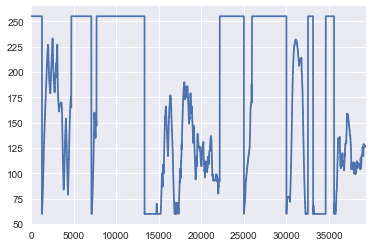

In [51]:
import pandas as pd
pandasDF = df.toPandas()
pandasDF['Hr'].plot()

Oh no! Look at that! We have upper and lower rails. Clearly we'll need to be mindful of this not handling the textbook healthy HR range as well as it listing high as perhaps a NaN.

Had I done further analysis of my friend's heart rate w.r.t. other metrics, I would have been using data that indicates she had a much higher heart rate than actual. Take this several steps further and we've now entered the realm of Fitbit's class action lawsuit from 2016.

## Clean

To resolve this circumstance, we can create a new DataFrame only containing records wherein HR is > 60 and < 255, as follows:

In [53]:
cleanerDF = df.filter(df['Hr']<255)
cleanerDF = cleanerDF.filter(cleanerDF['Hr']>60)

In [54]:
cleanerDF.describe(['Hr']).show()

+-------+------------------+
|summary|                Hr|
+-------+------------------+
|  count|             17836|
|   mean|132.86286162816776|
| stddev|  43.4514294410181|
|    min|                61|
|    max|               233|
+-------+------------------+



As a result, my friend is much happier with this average heart rate, though she did bug me for more interesting results, which I'll get to in another notebook.